### Imports

Esta célula de código faz as importações necessária para o funcionamento do projeto

- **os**: Permite a manipulação de sistema de ficheiros e operações em pastas
- **shuntil**: Fornece várias operações, como copiar, mover, remover pastas
- **path**: Fornece classes para manipulação de *paths*
- **image_dataset_from_directory**: Utilizado para carregar um conjunto de dados de imagens a partir de uma pasta
- **keras,layers, models**: Submódulos do Keras, utilizados para construir arquiteturas de modelos de redes neuronais
- **tensorflow**: Biblioteca de código *open-source*, para computação numérica e implementação de algoritmos de aprendizagem
- **EarlyStopping**: Callback para utilizar durante o treino dos modelos para interromper o processo caso não exista melhorias métricas
- **ModelCheckpoint**: Callback para utilizar durante o treino dos modelos para guardar o processo caso não exista melhorias métricas
- **matplotlib**: Biblioteca para criar gráficos e visualizações que ajudam na análise dos resultados do treino dos modelos

In [1]:
import os, shutil
from pathlib import Path
from keras.utils import image_dataset_from_directory
from tensorflow import keras
from keras import layers
from keras import models
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt


2024-06-22 21:38:55.664825: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-22 21:38:56.825137: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Reunir as imagens
**Atenção**: esta célula de código só é necessaria correr uma vez, apesar de estar em todos os *notebooks*

Nesta célula de código, fazemos a junção de todas as imagens das pastas de treino (*train1*, *train3*, *train4*, *train5*) numa só pasta, chamada de "temp_train", que vai conter todo o conteudo das pastas de treino, assim tendo um dataset único com bastantes imagens.


In [ ]:
# Lista de subpastas (train1, train3, etc.)
subfolders = ['train1', 'train3', 'train4', 'train5']

# Criar a estrutura temporária
Path(temp_train_dir).mkdir(parents=True, exist_ok=True)

# Iterar sobre cada subpasta
for subfolder in subfolders:
    subfolder_path = os.path.join(train_dir, subfolder)

    for class_folder in os.listdir(subfolder_path):
        class_folder_path = os.path.join(subfolder_path, class_folder)

        if os.path.isdir(class_folder_path):
            # Caminho destino para mover os arquivos
            dest_path = os.path.join(temp_train_dir, class_folder)

            if not os.path.exists(dest_path):
                os.makedirs(dest_path)

            # Mover todos os arquivos da subpasta para a pasta destino
            for filename in os.listdir(class_folder_path):
                file_path = os.path.join(class_folder_path, filename)
                shutil.copy(file_path, dest_path)

### Carregar as imagens

Esta célula de código define váriaveis aos caminhos das diretorias

Após ser "corrido" a célula de código acima, é possivel carregar a nova pasta chamada de temp_train juntamente com as pastas de validação, e de testes.


In [2]:
temp_train_dir = 'temp_train'
validation_dir = 'train2'
test_dir = 'test'

### Definir tamanho de imagem e tamanho de batch

Nesta célula de código é definido:
- Uma IMG_SIZE = 32, sendo assim, define o tamanho da imagem para 32x32 pixeis, sendo um tamanho relativemente pequeno, a velocidade do treino do modelo vai ser mais rapido, pois este possui menos informação do que por exemplo num IMG_SIZE = 150 (150x150 pixeis)
- Um BATCH_SIZE = 32, que define o tamanho do lote de dados que serão "alimentados" no modelo durante o treino.
- O conjunto de dados dos diferentes datasets, nomeadamente o temp_train_dir, o validation_dir e o test_dir.
- O label_mode como categorical, pois sendo o nosso problema de classificação, é o mais indicado.

In [3]:
IMG_SIZE = 32
BATCH_SIZE = 32

train_dataset = image_dataset_from_directory(
  temp_train_dir,
  image_size=(IMG_SIZE, IMG_SIZE),
  batch_size=BATCH_SIZE,
  label_mode='categorical')

validation_dataset = image_dataset_from_directory(
  validation_dir,
  image_size=(IMG_SIZE, IMG_SIZE),
  batch_size=BATCH_SIZE,
  label_mode='categorical')

test_dataset = image_dataset_from_directory(
  test_dir,
  image_size=(IMG_SIZE, IMG_SIZE),
  batch_size=BATCH_SIZE,
  label_mode='categorical')

Found 40000 files belonging to 10 classes.


2024-06-22 21:39:12.886500: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-22 21:39:13.023125: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-22 21:39:13.023285: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-22 21:39:13.026022: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-06-22 21:39:13.026132: I external/local_xla/xla/stream_executor

Found 10000 files belonging to 10 classes.
Found 10000 files belonging to 10 classes.


Found 40000 files belonging to 10 classes.

Found 10000 files belonging to 10 classes.

Found 10000 files belonging to 10 classes.



### Aplicamos a *data augmentation*

- **layers.RandomFlip("horizontal")** - é aplicado uma rotação horizontal aleatória às imagens
- **layers.RandomRotation(0.1)** - é aplicação uma rotação aleatória às imagens, dentro de um intervalo (no caso 0.1 = 10%)
- **layers.RandomZoom(0.2)** - é feito um zoom aleatorio as imagens dentro de um intervalo (no caso 0.2 = 20%)

In [4]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.2),
  ]
)

### Exibir imagens

É feito a conversão de cada elemento do lote 'data_batch[i]' e converte-o para um *unsigned integer* de 8 *bits*, algo comum em imagens.

Nesta célula conseguimos visualizar as primeiras 5 imagens do primeiro batch de dados do conjunto de treinamento, conseguindo assim verificar visualmente que as entradas dos dados a serem processados estão corretos.

Aqui é exibido uma imagem, mas com quatro variações, com a *data augmentation* aplicada

2024-06-21 14:44:51.004938: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


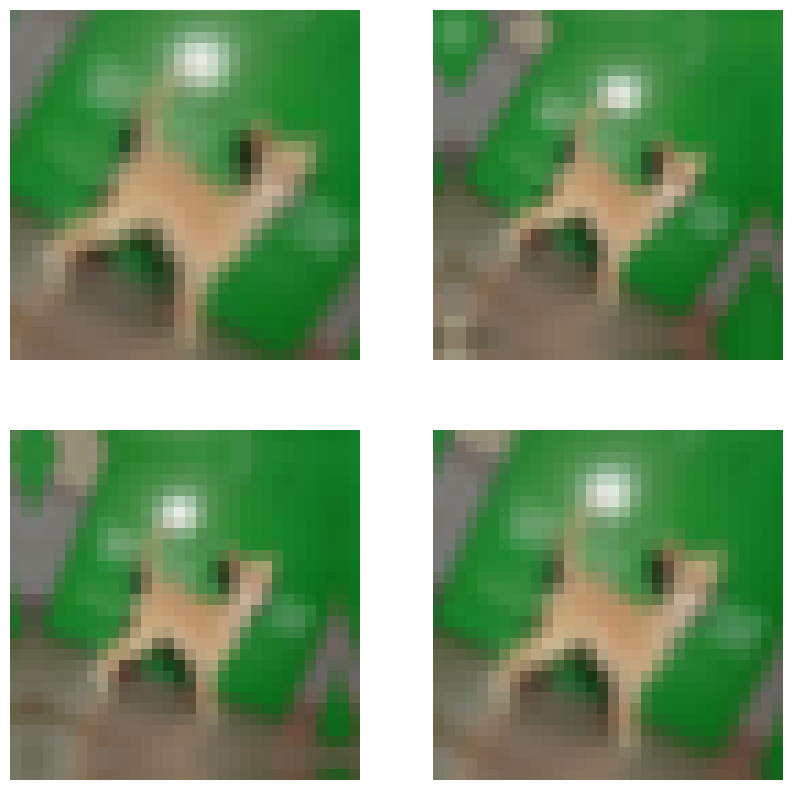

In [5]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
  for i in range(4):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(2, 2, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

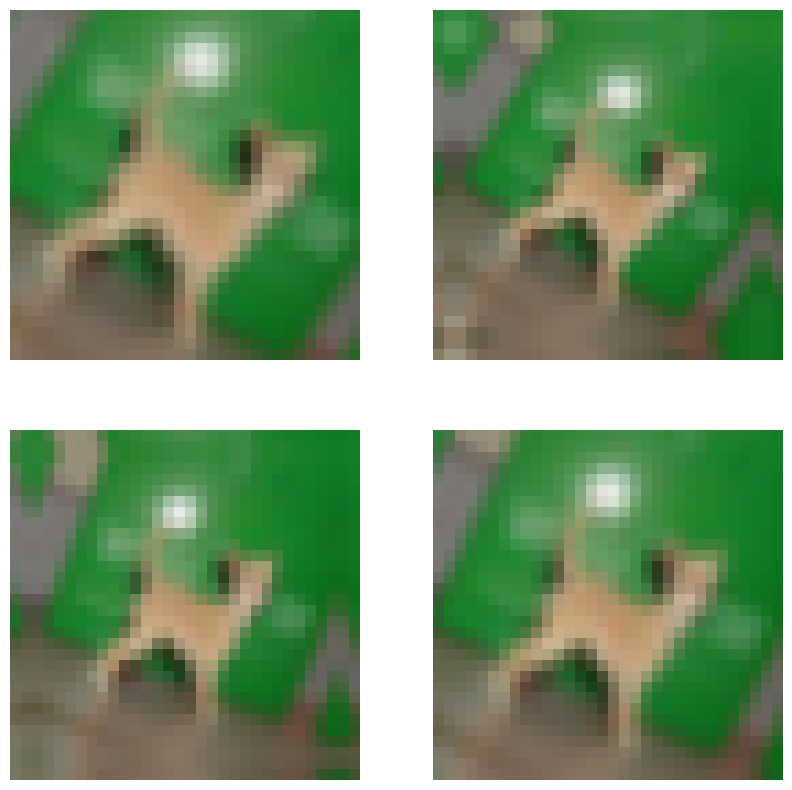

### Print do test_dataset

Nesta célula conseguimos rapidamente ver as dimensões dos lotes, certificando que foram corretamente carregados.

In [5]:
for data_batch, labels_batch in test_dataset:
    print('Data batch shape:', data_batch.shape)
    print('Labels batch shape:', labels_batch.shape)
    break 

Data batch shape: (32, 32, 32, 3)
Labels batch shape: (32, 10)


Data batch shape: (32, 32, 32, 3)

Labels batch shape: (32, 10)

### Construir o modelo

Nesta célula de código definimos:

- No input a altura com IMG_SIZE, a largura com IMG_SIZE, e finalmente o *RGB*, com 3 (os três canais de cor)
- Um *rescaling* para normalizar os valores dos pixeis de 0 a 255 para 0 a 1, fazemos isto a dividir cada pixel por 255.
- Adicionamos as camadas convolucionais, seguidas por outras camadas de max pooling.
- O Conv2D aplica convolução com 32 filtros de tamanho 3x3
- O MaxPooling2D reduz a dimensionalidade pela metade
- Repetimos este procedimento três vezes, seguidas das camadas de max pooling para conseguir extrair caracteristicas das imagens e reduzir a dimensionalidade das mesmas
- De seguida com o **layers.Flatten()(x)** transformamos os dados de saida das camadas convulacionais num vetor unidimensional.
- Com o **layers.Dense(512, activation="relu")(x)** adicionamos uma camada com 512 unidades e a função **relu**, isto permite que a rede aprenda combinações mais complexas das caracteristicas extraidas.
- Depois com o **layers.Dense(10,activation="softmax")(x)** definimos a camada de saida, com 10 unidades (número de sub-pastas em cada pasta de treino), e ainda utilizamos a ativação **softmax** que normalmente usada para problemas de classificação.
- Por fim, criamos o novo modelo com o **keras.Model(inputs=inputs, outputs=outputs)**, onde os *inputs* são as camadas de entrada e os *outputs* são as camadas de saida anteriormente definidas

In [6]:
inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))

x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)


x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(512, activation="relu")(x)
outputs = layers.Dense(10, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

### Compilar o modelo

Nesta célula de código, configuramos o processo de compilação do modelo construido anteriormente.

- **loss='categorical_crossentropy'** utilizamos a função de perda 'categorical_crossentropy', pois é uma função utilizada normalmente em problemas de classificação
- **optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4)** aqui escolhemos o otimizador RMSprop, com uma taxa de *learning* de 0.0001
-  **metrics=['acc']** por fim, definimos a métrica para avaliar o desempenho do modelo durante o treino para ser a *accuracy* 

In [7]:
model.compile(
  loss='categorical_crossentropy',
  optimizer=tf.keras.optimizers.RMSprop(learning_rate=1e-4),
  metrics=['acc'])

### Treinar o modelo

Nesta célula de código implementamos:


- EarlyStopping é definido para este monitorizar a 'val_loss', e se esta não tiver alterações significativas após 5 *epochs*, vai fazer a pausa do algoritmo.

- Definimos o model_checkpoint para este guardar **apenas** os melhores resultados, conforme o valor da 'val_loss'. Este guarda o melhor resultado dentro da pasta 'models' com o nome adequado.

- Iniciamos o treino do modelo com o conjunto de dados de treinamento, definido ainda o número de epochs como 30, e avaliando o mesmo com o conjunto de dados de validaçao.

In [8]:
early_stopping = EarlyStopping(
    monitor='val_loss',  
    patience=5,  
    restore_best_weights=True  
)

model_checkpoint = keras.callbacks.ModelCheckpoint(
    filepath='models/Projeto_S_from_scratch_com_data_augmentation_best.keras',
    save_best_only=True,
    monitor='val_loss'
)

callbacks = [early_stopping, model_checkpoint]

history = model.fit(
    train_dataset,
    epochs=30,
    verbose=1,
    callbacks=callbacks,
    validation_data=validation_dataset
)

Epoch 1/30


I0000 00:00:1719088837.304417  181962 service.cc:145] XLA service 0x7f68ec009630 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1719088837.304519  181962 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 2060, Compute Capability 7.5
2024-06-22 21:40:37.327337: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-06-22 21:40:37.469906: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8907


  36/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - acc: 0.1041 - loss: 2.3072  

I0000 00:00:1719088840.295333  181962 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - acc: 0.2033 - loss: 2.1336 - val_acc: 0.3638 - val_loss: 1.7633
Epoch 2/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - acc: 0.3637 - loss: 1.7290 - val_acc: 0.4402 - val_loss: 1.5639
Epoch 3/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - acc: 0.4176 - loss: 1.5964 - val_acc: 0.4785 - val_loss: 1.4641
Epoch 4/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - acc: 0.4553 - loss: 1.5073 - val_acc: 0.5024 - val_loss: 1.3978
Epoch 5/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - acc: 0.4827 - loss: 1.4368 - val_acc: 0.5283 - val_loss: 1.3401
Epoch 6/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - acc: 0.5099 - loss: 1.3857 - val_acc: 0.5396 - val_loss: 1.3030
Epoch 7/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - acc: 0.5273 - loss: 1.3343 - val_acc: 0.5348 - val_loss: 1.3135
Epoch 8/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - acc: 0.5423 - loss: 1.2949 - val_acc: 0.5666 - val_loss: 1.2241
Epoch 9/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/s

Epoch 1/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - acc: 0.2033 - loss: 2.1336 - val_acc: 0.3638 - val_loss: 1.7633

Epoch 2/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - acc: 0.3637 - loss: 1.7290 - val_acc: 0.4402 - val_loss: 1.5639

Epoch 3/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - acc: 0.4176 - loss: 1.5964 - val_acc: 0.4785 - val_loss: 1.4641

Epoch 4/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - acc: 0.4553 - loss: 1.5073 - val_acc: 0.5024 - val_loss: 1.3978

Epoch 5/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - acc: 0.4827 - loss: 1.4368 - val_acc: 0.5283 - val_loss: 1.3401

Epoch 6/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - acc: 0.5099 - loss: 1.3857 - val_acc: 0.5396 - val_loss: 1.3030

Epoch 7/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - acc: 0.5273 - loss: 1.3343 - val_acc: 0.5348 - val_loss: 1.3135

Epoch 8/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - acc: 0.5423 - loss: 1.2949 - val_acc: 0.5666 - val_loss: 1.2241

Epoch 9/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - acc: 0.5613 - loss: 1.2551 - val_acc: 0.5811 - val_loss: 1.1829

Epoch 10/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - acc: 0.5725 - loss: 1.2210 - val_acc: 0.5958 - val_loss: 1.1565

Epoch 11/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - acc: 0.5839 - loss: 1.1904 - val_acc: 0.6064 - val_loss: 1.1256

Epoch 12/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - acc: 0.5891 - loss: 1.1639 - val_acc: 0.6068 - val_loss: 1.1327

Epoch 13/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - acc: 0.5997 - loss: 1.1423 - val_acc: 0.6190 - val_loss: 1.0979

Epoch 14/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - acc: 0.6055 - loss: 1.1216 - val_acc: 0.6379 - val_loss: 1.0527

Epoch 15/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - acc: 0.6170 - loss: 1.0987 - val_acc: 0.6387 - val_loss: 1.0510

Epoch 16/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - acc: 0.6196 - loss: 1.0761 - val_acc: 0.6407 - val_loss: 1.0282

Epoch 17/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - acc: 0.6315 - loss: 1.0615 - val_acc: 0.6496 - val_loss: 1.0072

Epoch 18/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - acc: 0.6349 - loss: 1.0477 - val_acc: 0.6569 - val_loss: 0.9944

Epoch 19/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - acc: 0.6412 - loss: 1.0232 - val_acc: 0.6562 - val_loss: 0.9895

Epoch 20/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - acc: 0.6452 - loss: 1.0198 - val_acc: 0.6576 - val_loss: 0.9760

Epoch 21/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - acc: 0.6544 - loss: 0.9956 - val_acc: 0.6501 - val_loss: 1.0190

Epoch 22/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - acc: 0.6571 - loss: 0.9806 - val_acc: 0.6429 - val_loss: 1.0328

Epoch 23/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - acc: 0.6627 - loss: 0.9686 - val_acc: 0.6703 - val_loss: 0.9586

Epoch 24/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - acc: 0.6644 - loss: 0.9569 - val_acc: 0.6699 - val_loss: 0.9440

Epoch 25/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - acc: 0.6733 - loss: 0.9406 - val_acc: 0.6763 - val_loss: 0.9409

Epoch 26/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - acc: 0.6763 - loss: 0.9274 - val_acc: 0.6766 - val_loss: 0.9271

Epoch 27/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - acc: 0.6782 - loss: 0.9185 - val_acc: 0.6782 - val_loss: 0.9318

Epoch 28/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - acc: 0.6816 - loss: 0.9067 - val_acc: 0.6852 - val_loss: 0.9045

Epoch 29/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - acc: 0.6840 - loss: 0.9020 - val_acc: 0.6906 - val_loss: 0.8877

Epoch 30/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - acc: 0.6916 - loss: 0.8867 - val_acc: 0.6876 - val_loss: 0.9051


### Avaliação do modelo

Aqui é representado o val_acc do modelo criado na célula de código anterior, este representa o valor da precisão da classificasão do conjunto de dados de validação

In [9]:
val_loss, val_acc = model.evaluate(validation_dataset)
print('val_acc:', val_acc)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - acc: 0.6909 - loss: 0.9049
val_acc: 0.6905999779701233


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - acc: 0.6909 - loss: 0.9049

val_acc: 0.6905999779701233

### Guardar o modelo criado

Guardamos o módelo com um nome apropriado, dentro da pasta 'models'

In [10]:
model.save('models/Projeto_S_from_scratch_com_data_augmentation.keras')

### Carregar o último melhor modelo

Carregamos o **best** modelo que fica guardado numa variavel chamada de loaded_model

De seguida fazemos o summary do mesmo para visualizar a sua arquitetura

In [12]:
loaded_model = tf.keras.models.load_model('models/Projeto_S_from_scratch_com_data_augmentation_best.keras')

loaded_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 32, 32, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         5,130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 722,070 (2.75 MB)

 Trainable params: 361,034 (1.38 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 361,036 (1.38 MB)

<pre style="white-space:pre;overflow-x:auto;line-height:normal;font-family:Menlo,'DejaVu Sans Mono',consolas,'Courier New',monospace">┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃<span style="font-weight: bold"> Layer (type)                    </span>┃<span style="font-weight: bold"> Output Shape           </span>┃<span style="font-weight: bold">       Param # </span>┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (<span style="color: #0087ff; text-decoration-color: #0087ff">InputLayer</span>)      │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">32</span>, <span style="color: #00af00; text-decoration-color: #00af00">32</span>, <span style="color: #00af00; text-decoration-color: #00af00">3</span>)      │             <span style="color: #00af00; text-decoration-color: #00af00">0</span> │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (<span style="color: #0087ff; text-decoration-color: #0087ff">Rescaling</span>)           │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">32</span>, <span style="color: #00af00; text-decoration-color: #00af00">32</span>, <span style="color: #00af00; text-decoration-color: #00af00">3</span>)      │             <span style="color: #00af00; text-decoration-color: #00af00">0</span> │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (<span style="color: #0087ff; text-decoration-color: #0087ff">Conv2D</span>)                 │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">30</span>, <span style="color: #00af00; text-decoration-color: #00af00">30</span>, <span style="color: #00af00; text-decoration-color: #00af00">32</span>)     │           <span style="color: #00af00; text-decoration-color: #00af00">896</span> │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (<span style="color: #0087ff; text-decoration-color: #0087ff">MaxPooling2D</span>)    │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">15</span>, <span style="color: #00af00; text-decoration-color: #00af00">15</span>, <span style="color: #00af00; text-decoration-color: #00af00">32</span>)     │             <span style="color: #00af00; text-decoration-color: #00af00">0</span> │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (<span style="color: #0087ff; text-decoration-color: #0087ff">Conv2D</span>)               │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">13</span>, <span style="color: #00af00; text-decoration-color: #00af00">13</span>, <span style="color: #00af00; text-decoration-color: #00af00">64</span>)     │        <span style="color: #00af00; text-decoration-color: #00af00">18,496</span> │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (<span style="color: #0087ff; text-decoration-color: #0087ff">MaxPooling2D</span>)  │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">6</span>, <span style="color: #00af00; text-decoration-color: #00af00">6</span>, <span style="color: #00af00; text-decoration-color: #00af00">64</span>)       │             <span style="color: #00af00; text-decoration-color: #00af00">0</span> │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (<span style="color: #0087ff; text-decoration-color: #0087ff">Conv2D</span>)               │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">4</span>, <span style="color: #00af00; text-decoration-color: #00af00">4</span>, <span style="color: #00af00; text-decoration-color: #00af00">128</span>)      │        <span style="color: #00af00; text-decoration-color: #00af00">73,856</span> │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (<span style="color: #0087ff; text-decoration-color: #0087ff">MaxPooling2D</span>)  │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">2</span>, <span style="color: #00af00; text-decoration-color: #00af00">2</span>, <span style="color: #00af00; text-decoration-color: #00af00">128</span>)      │             <span style="color: #00af00; text-decoration-color: #00af00">0</span> │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (<span style="color: #0087ff; text-decoration-color: #0087ff">Flatten</span>)               │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">512</span>)            │             <span style="color: #00af00; text-decoration-color: #00af00">0</span> │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (<span style="color: #0087ff; text-decoration-color: #0087ff">Dropout</span>)               │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">512</span>)            │             <span style="color: #00af00; text-decoration-color: #00af00">0</span> │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (<span style="color: #0087ff; text-decoration-color: #0087ff">Dense</span>)                   │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">512</span>)            │       <span style="color: #00af00; text-decoration-color: #00af00">262,656</span> │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (<span style="color: #0087ff; text-decoration-color: #0087ff">Dense</span>)                 │ (<span style="color: #00d7ff; text-decoration-color: #00d7ff">None</span>, <span style="color: #00af00; text-decoration-color: #00af00">10</span>)             │         <span style="color: #00af00; text-decoration-color: #00af00">5,130</span> │
└─────────────────────────────────┴────────────────────────┴───────────────┘
</pre>
<pre style="white-space:pre;overflow-x:auto;line-height:normal;font-family:Menlo,'DejaVu Sans Mono',consolas,'Courier New',monospace"><span style="font-weight: bold"> Total params: </span><span style="color: #00af00; text-decoration-color: #00af00">722,070</span> (2.75 MB)
</pre>
<pre style="white-space:pre;overflow-x:auto;line-height:normal;font-family:Menlo,'DejaVu Sans Mono',consolas,'Courier New',monospace"><span style="font-weight: bold"> Trainable params: </span><span style="color: #00af00; text-decoration-color: #00af00">361,034</span> (1.38 MB)
</pre>
<pre style="white-space:pre;overflow-x:auto;line-height:normal;font-family:Menlo,'DejaVu Sans Mono',consolas,'Courier New',monospace"><span style="font-weight: bold"> Non-trainable params: </span><span style="color: #00af00; text-decoration-color: #00af00">0</span> (0.00 B)
</pre>
<pre style="white-space:pre;overflow-x:auto;line-height:normal;font-family:Menlo,'DejaVu Sans Mono',consolas,'Courier New',monospace"><span style="font-weight: bold"> Optimizer params: </span><span style="color: #00af00; text-decoration-color: #00af00">361,036</span> (1.38 MB)
</pre>


### Treinar de novo, mas a partir do último melhor modelo

Aqui voltamos a repetir o processo de treinamento com 30 *epochs*, no entanto em vez de começar do "zero" treinamos a partir do último melhor modelo.

Apesar do EarlyStopping estar na celula de código, este não está a ser utilizado, logo este treino percorreu as **30** *epochs* ao contrário modelo S_from_scratch_without_data_augmentation

In [13]:
early_stopping = EarlyStopping(
    monitor='val_loss',  
    patience=5,  
    restore_best_weights=True  
)

loaded_model_checkpoint = [
  keras.callbacks.ModelCheckpoint(
  filepath='models/Projeto_S_from_scratch_com_data_augmentation_best.keras',
  save_best_only=True,
  monitor='val_loss')
]

#callbacks = [early_stopping, loaded_model_checkpoint]
callbacks = [loaded_model_checkpoint]

historyAfter = loaded_model.fit(train_dataset, epochs=30, verbose=1, callbacks=callbacks, validation_data=validation_dataset)

Epoch 1/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - acc: 0.6919 - loss: 0.8853 - val_acc: 0.6765 - val_loss: 0.9303
Epoch 2/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - acc: 0.6918 - loss: 0.8805 - val_acc: 0.6973 - val_loss: 0.8742
Epoch 3/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - acc: 0.7016 - loss: 0.8584 - val_acc: 0.6964 - val_loss: 0.8660
Epoch 4/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - acc: 0.6993 - loss: 0.8566 - val_acc: 0.6949 - val_loss: 0.8832
Epoch 5/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - acc: 0.7030 - loss: 0.8485 - val_acc: 0.6947 - val_loss: 0.8732
Epoch 6/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - acc: 0.7098 - loss: 0.8334 - val_acc: 0.7066 - val_loss: 0.8487
Epoch 7/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - acc: 0.7099 - loss: 0.8279 - val_acc: 0.7073 - val_loss: 0.8573
Epoch 8/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - acc: 0.7172 - loss: 0.8200 - val_acc: 0.7032 - val_loss: 0.8446
Epoch 9/30
1250/1250 ━━━━━━━━━━━━━━━━━━━

Epoch 1/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 9s 5ms/step - acc: 0.6919 - loss: 0.8853 - val_acc: 0.6765 - val_loss: 0.9303

Epoch 2/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - acc: 0.6918 - loss: 0.8805 - val_acc: 0.6973 - val_loss: 0.8742

Epoch 3/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - acc: 0.7016 - loss: 0.8584 - val_acc: 0.6964 - val_loss: 0.8660

Epoch 4/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - acc: 0.6993 - loss: 0.8566 - val_acc: 0.6949 - val_loss: 0.8832

Epoch 5/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - acc: 0.7030 - loss: 0.8485 - val_acc: 0.6947 - val_loss: 0.8732

Epoch 6/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - acc: 0.7098 - loss: 0.8334 - val_acc: 0.7066 - val_loss: 0.8487

Epoch 7/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - acc: 0.7099 - loss: 0.8279 - val_acc: 0.7073 - val_loss: 0.8573

Epoch 8/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - acc: 0.7172 - loss: 0.8200 - val_acc: 0.7032 - val_loss: 0.8446

Epoch 9/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - acc: 0.7148 - loss: 0.8150 - val_acc: 0.6980 - val_loss: 0.8551

Epoch 10/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - acc: 0.7188 - loss: 0.8036 - val_acc: 0.7125 - val_loss: 0.8314

Epoch 11/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - acc: 0.7263 - loss: 0.7933 - val_acc: 0.7138 - val_loss: 0.8205

Epoch 12/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - acc: 0.7256 - loss: 0.7903 - val_acc: 0.7064 - val_loss: 0.8305

Epoch 13/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - acc: 0.7313 - loss: 0.7796 - val_acc: 0.7141 - val_loss: 0.8239

Epoch 14/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - acc: 0.7285 - loss: 0.7783 - val_acc: 0.7071 - val_loss: 0.8372

Epoch 15/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - acc: 0.7284 - loss: 0.7663 - val_acc: 0.6958 - val_loss: 0.9027

Epoch 16/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - acc: 0.7314 - loss: 0.7722 - val_acc: 0.7180 - val_loss: 0.8157

Epoch 17/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - acc: 0.7359 - loss: 0.7625 - val_acc: 0.7110 - val_loss: 0.8448

Epoch 18/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - acc: 0.7355 - loss: 0.7559 - val_acc: 0.7242 - val_loss: 0.7955

Epoch 19/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - acc: 0.7387 - loss: 0.7482 - val_acc: 0.7126 - val_loss: 0.8272

Epoch 20/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - acc: 0.7449 - loss: 0.7357 - val_acc: 0.7221 - val_loss: 0.7972

Epoch 21/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - acc: 0.7457 - loss: 0.7354 - val_acc: 0.7159 - val_loss: 0.8304

Epoch 22/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - acc: 0.7470 - loss: 0.7291 - val_acc: 0.7204 - val_loss: 0.8043

Epoch 23/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - acc: 0.7485 - loss: 0.7248 - val_acc: 0.7240 - val_loss: 0.7934

Epoch 24/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - acc: 0.7537 - loss: 0.7131 - val_acc: 0.7119 - val_loss: 0.8531

Epoch 25/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - acc: 0.7509 - loss: 0.7104 - val_acc: 0.7237 - val_loss: 0.7949

Epoch 26/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - acc: 0.7523 - loss: 0.7080 - val_acc: 0.7170 - val_loss: 0.8150

Epoch 27/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - acc: 0.7561 - loss: 0.7010 - val_acc: 0.7216 - val_loss: 0.7966

Epoch 28/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - acc: 0.7545 - loss: 0.6987 - val_acc: 0.7222 - val_loss: 0.8032

Epoch 29/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - acc: 0.7608 - loss: 0.6876 - val_acc: 0.7283 - val_loss: 0.7775

Epoch 30/30
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 7s 5ms/step - acc: 0.7601 - loss: 0.6857 - val_acc: 0.7221 - val_loss: 0.8010


### Avaliação do modelo treinado apartir do último melhor

- É possivel ver uma pequena melhoria na accuracy do modelo após o "segundo" treinamento

In [14]:
val_loss, val_acc = loaded_model.evaluate(validation_dataset)
print('val_acc:', val_acc)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.7130 - loss: 0.8191
val_acc: 0.722100019454956


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.7130 - loss: 0.8191

val_acc: 0.722100019454956

### Desenhar graficos

É gerado os gráficos com os modelos previamente treinados, tanto com o antes de treinar a partir do ultimo melhor, como com o após treinar o último melhor.

Os graficos mostram a accuracy e a loss, durante o processo de treino e validação ao longo das *epochs*.

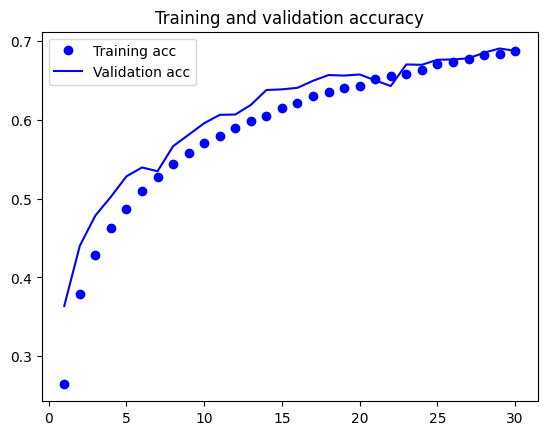

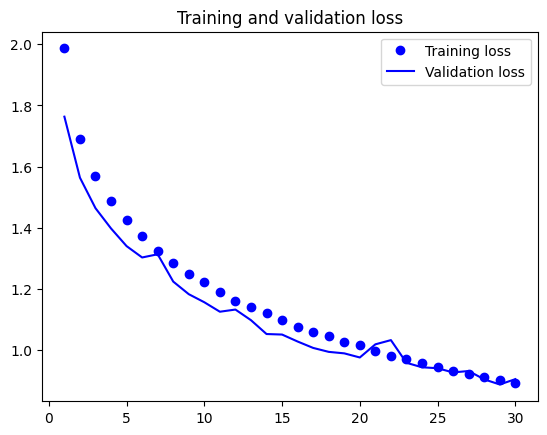

In [15]:
# Gráfico de accuracy ANTES de treinar a partir do ultimo melhor modelo


acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

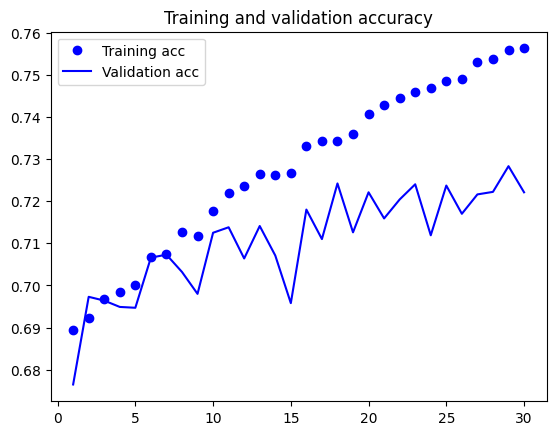

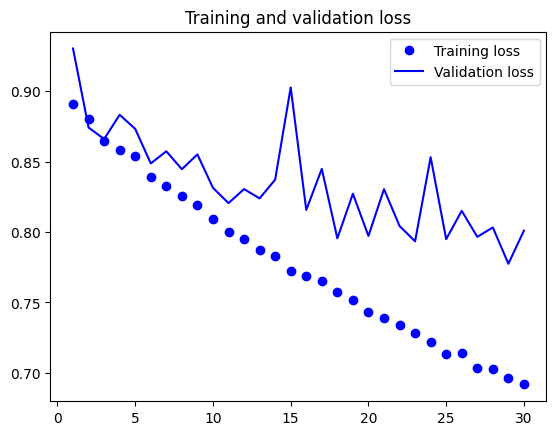

In [16]:
# Gráfico de accuracy DEPOIS de treinar a partir do ultimo melhor modelo


acc = historyAfter.history['acc']
val_acc = historyAfter.history['val_acc']
loss = historyAfter.history['loss']
val_loss = historyAfter.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

### Relatório

#### Objetivo

Neste *notebook* desenvolvemos uma rede convolucional com o objetivo de prevenir os problemas de *overfitting* que ocorreram no modelo do *notebook* Projeto_S_from_scratch_versaoFinal, e nele a rede convolucional é composta pelas seguintes camadas:

- **Camada de entrada** que recebe imagens com dimensão 32x32 pixeis e 3 canais de cor (RGB);
- **Camada de normalização** dos dados de entrada que reescala os valores dos pixeis da imagem para um intervalo [0, 1];
- **Camada convolucional** com 32 filtros, cada um de tamanho 3x3;
- **Camada de maxpooling** com janelas de *pooling* 2x2;
- **Camada convolucional** com 64 filtros, cada um de tamanho 3x3;
- **Camada de maxpooling** com janelas de *pooling* 2x2;
- **Camada convolucional** com 128 filtros, cada um de tamanho 3x3;
- **Camada de maxpooling** com janelas de *pooling* 2x2;
- **Camada flatten** que agrupa todo o *output shape* numa matriz de uma só dimensão;
- **Camada dropout** com taxa de +dropout* de 0.5 para regularização;
- **Camada dense** com 512 unidades e ativação ReLU;
- **Camada dense** é a camada de saída que representa as 10 classes de saída com ativação softmax.

#### Desenvolvimento

Desenvolvemos a seguinte rede:

| Layer (type)                  | Output Shape         | Param #   |
|-------------------------------|----------------------|-----------|
| input_layer_1 (InputLayer)    | (None, 32, 32, 3)    | 0         |
| rescaling (Rescaling)         | (None, 32, 32, 3)    | 0         |
| conv2d (Conv2D)               | (None, 30, 30, 32)   | 896       |
| max_pooling2d (MaxPooling2D)  | (None, 15, 15, 32)   | 0         |
| conv2d_1 (Conv2D)             | (None, 13, 13, 64)   | 18,496    |
| max_pooling2d_1 (MaxPooling2D)| (None, 6, 6, 64)     | 0         |
| conv2d_2 (Conv2D)             | (None, 4, 4, 128)    | 73,856    |
| max_pooling2d_2 (MaxPooling2D)| (None, 2, 2, 128)    | 0         |
| flatten (Flatten)             | (None, 512)          | 0         |
| dropout (Dropout)             | (None, 512)          | 0         |
| dense (Dense)                 | (None, 512)          | 262,656   |
| dense_1 (Dense)               | (None, 10)           | 5,130     |

Nesta estrutura podemos notar que está presente uma **camada de *Dropout***, que tem como objetivo desativar aleatoriamente uma fração dos neurónios da camada anterior em cada atualização de peso e isso, por sua vez, força a rede a não depender excessivamente de neurónios específicos, promovendo a redundância e a generalização da aprendizagem.

Esta rede, para além do conjunto de dados de treino, recebe também como *input* os dados com ***data augmentation***, isto são, as imagens do conjunto de treino transformadas com rotações horizontais aleatórias e *zooms*, geradas no momento em que é executada a rede para aumentar a variedade do conjunto de dados de treino e assim impedir que a rede se acostume aos dados de treino e obtenha melhores resultados na classificação dos dados de validação. Isso está provado nos gráficos seguintes, que mostram uma linha de aprendizagem muito mais perto uma da outra entre os valores de precisão da classificação dos dados de treino e dos dados de validação:

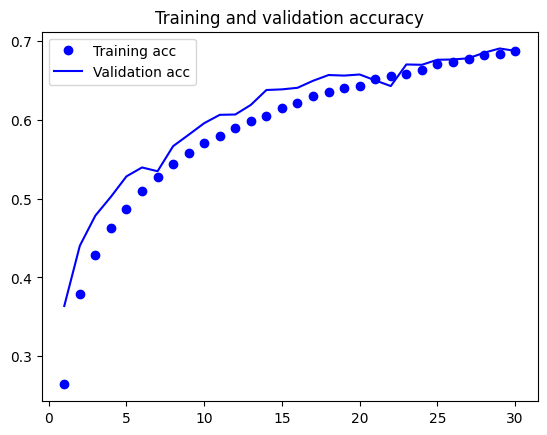

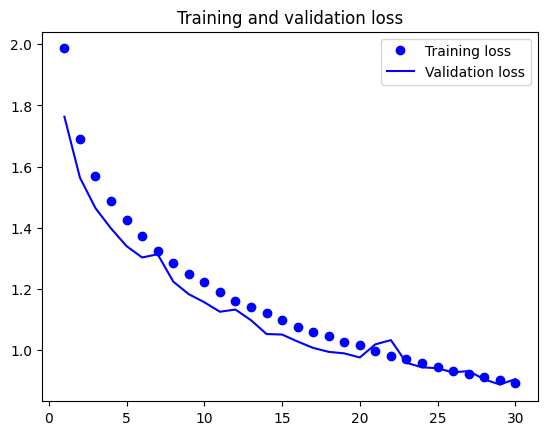

**val_acc:** 0.6905999779701233

Decidimos carregar o melhor modelo obtido (Projeto_S_from_scratch_com_data_augmentation_best.keras) depois do treino completo e tentar melhorá-lo e assim geramos os seguintes resultados:

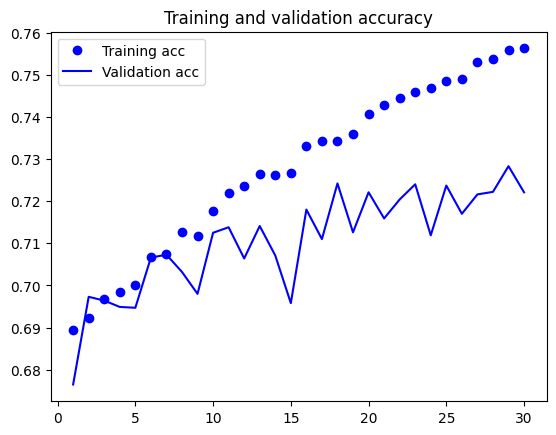

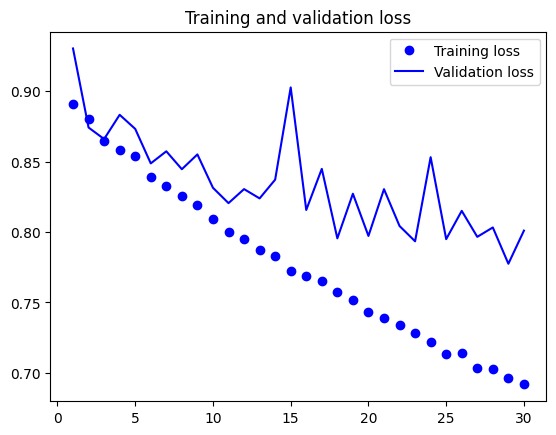

**val_acc:** 0.722100019454956

#### Conclusão

Em comparação ao modelo obtido no *notebook* Projeto_S_from_scratch_sem_data_augmentation é possível observar que tendo implementado a funcionalidade de *data augmentation* e adicionado a camda de *dropout*, houve um impacto nos resultados de precisão na classificação do conjunto de dados de validação, dando à rede uma maior capacidade de generalização.
